In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
from pathlib import Path
from random import choices, randint
import mir_eval
import scipy
import sklearn

## Loading in the data
> The audio should be placed in the root directory inside a folder named "data". Inside the data folder there should be two folders, "lofi" and "non-lofi". Place the data you want in those folders accordingly

In [2]:
def _get_paths():
    '''
    Not meant to be called externally. Used by load_data.
    
    Prepares the file paths for the audio files in the data folder (lofi and non-lofi directories)
    for data load
    '''
    lofi_file_paths = []
    non_lofi_file_paths = []
    lofi_basepath = Path("../data/lofi")
    non_lofi_basepath = Path("../data/non-lofi")
    lofi_files_in_basepath = lofi_basepath.iterdir()
    non_lofi_files_in_basepath = non_lofi_basepath.iterdir()
    # Iterate over items in the lofi folder and save filepaths
    for lofi_item in lofi_files_in_basepath:
        if lofi_item.is_file():
            lofi_file_paths.append(lofi_item)
    # Iterate over items in the non-lofi folder and save filepaths
    for non_lofi_item in non_lofi_file_paths:
        if non_lofi_item.is_file():
            non_lofi_file_paths.append(non_lofi_item)
    
    return lofi_file_paths, non_lofi_file_paths

def load_data(srate):
    '''
    Loads the data from the data folder into numpy data arrays representing the audio files.
    
    params:
        srate: The sample rate to load the data in. Default is 22050 Hz (Good enough for now)
    
    returns: an array of genre arrays. Each genre array contains audio arrays for each audio files 
        [0]: lofi data arrays
        [1]: non-lofi data arrays
    '''
    lofi_paths, non_lofi_paths = _get_paths()
    lofi_data_array = []
    non_lofi_data_array = []
    
    # load in lofi data
    for path in lofi_paths:
        data, _ = librosa.load(path, sr=srate)
        lofi_data_array.append(data)
        
    # load in non-lofi data
    for path in non_lofi_paths:
        data, _ = librosa.load(path, sr=srate)
        non_lofi_data_array.append(data)
    return lofi_data_array, non_lofi_data_array

In [3]:
srate = 22050
lofi, non_lofi = load_data(srate)

In [ ]:
ipd.Audio(data=lofi[0], rate=srate)

## Pre-processing

In [5]:
def feature_extraction(data, srate, hop_size=512 ):
    '''
    Extracts the features
    
    This will be used to organize the different sounds in lofi music (drums, bass, high_notes, etc)
    
    params:
        data: the audio data array of a single audio clip to extract features from
        srate: sample rate
        hop_length: hop length
        
    returns:
        an array of features
            [0]: zero cross rate mean
            [1]: zero cross rate standard deviation
            [2]: spectral centroid mean
            [3]: spectral centroid standard deviation
            [4]: spectral bandwidth mean
            [5]: spectral bandwidth standard deviation
            [6]: spectral flatness mean
            [7]: spectral flatness standard deviation
            [8]: spectral rolloff mean
            [9]: spectral rolloff standard deviation
    '''
    # Features
    zcr = librosa.feature.zero_crossing_rate(data)
    
    features = [zcr.mean(), zcr.std()]
    
    #SPECTRAL FEATURES
    spectral_features = extract_spectral(data, srate, hop_size)  #store spectral features in array
    
    return np.concatenate([features, spectral_features])

In [6]:
# Taken from Jordie's 'Audio Feature Extraction' notebook
# called in 'feature_extraction(data)'
def extract_spectral(data, srate, hop_length=512):
    '''
    Extracts spectral features
    
    Called in 'feature_extraction(data)'
    
    Taken from Jordie's 'Audio Feature Extraction' notebook

    params:
        data: the audio data array of a single audio clip to extract features from
        srate: sample rate
        hop_length: hop length
        
    returns:
        an list of np arrays called a feature vector
    '''
    # np.array
    centroid = librosa.feature.spectral_centroid(data, sr=srate, hop_length=hop_length) 
    bandwidth = librosa.feature.spectral_bandwidth(data, sr=srate, hop_length=hop_length)
    flatness = librosa.feature.spectral_flatness(data, hop_length=hop_length)
    rolloff = librosa.feature.spectral_rolloff(data, sr=srate, hop_length=hop_length)
    
    # feature vector list
    feature_vector = [
        centroid.mean(),
        centroid.std(),
        bandwidth.mean(),
        bandwidth.std(),
        flatness.mean(),
        flatness.std(),
        rolloff.mean(),
        rolloff.std()
    ]
    
    return feature_vector

In [ ]:
def audio_fingerprint(data):
    '''
    Create the audio fingerprint
    
    
    params:
        data: the audio data array of a single audio clip to create the fingerprint of
        
    returns:
        an audio fingerprint of the given data array
    '''
    f, t, sxx = scipy.signal.spectrogram(data)
    peaks = scipy.signal.find_peaks(f, height, threshold, distance, prominence)
    fingerprint = fingerprint_hash(peaks)
    pass

In [ ]:
def generate_mfcc(data):
    '''
    Create the mfcc feature vector

    params:
        data: the audio data array of a single audio clip to create the MFCC vector for
        
    returns:
        an MFCC vector of the given vector
    '''
    
    mfcc_data = librosa.feature.mfcc(data)
    return mfcc_data


## Data Organization

In [ ]:
lofi_af = [audio_fingerprint(data) for data in lofi]
non_lofi_af = [audio_fingerprint(data) for data in non_lofi]

In [ ]:
lofi_mfccs = [generate_mfcc(data) for data in lofi]
non_lofi_mfccs = [generate_mfcc(data) for data in non_lofi]

## Sound Bank Generation

In [7]:
def generate_soundbank(dataset, srate):
    '''
    Groups similar sounds using K-means clustering
    
    params:
        dataset: The dataset to group sounds for
        srate: sample rate of the data in the dataset
        
    returns:
        groups of the sounds (bass sounds, drum sounds, etc)
    '''
    # pre-onset buffer are the samples before the onset starts
    # post-onset buffer are the samples after the onset starts
    # pre-onset + post-onset = frame size
    pre_onset_buffer = 1024
    post_onset_buffer = 3072
    gaps = []
    segments = []
    features = []
    for data in dataset:
        onset_frames = librosa.onset.onset_detect(data)
        onset_samples = librosa.frames_to_samples(onset_frames)
        for idx in range(len(onset_samples)):
            onset = onset_samples[idx]
            
            # Extract Main Audio Segments
            frame_start = onset - pre_onset_buffer
            frame_end = onset + post_onset_buffer
            if frame_start < 0 or frame_end > len(data):
                continue
            segment = data[frame_start:frame_end]
            segments.append(segment)
            features.append(feature_extraction(segment, srate))
            
            # Extract Background Segments (Gaps)
            if idx+1 >= len(onset_samples):
                continue
            onset = onset_samples[idx]
            start_gap_sample = onset + post_onset_buffer
            end_gap_sample = onset_samples[idx+1] - pre_onset_buffer
            gap = []
            for gap_sample in range(start_gap_sample, end_gap_sample+1):
                gap.append(data[gap_sample])
            gaps.append(gap)
            
    min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))
    scaled_features = min_max_scaler.fit_transform(features)
    clusterer = sklearn.cluster.KMeans(3)
    labels = clusterer.fit_predict(scaled_features)
    
    plt.figure(figsize=(20,5))
    plt.scatter(scaled_features[labels==0,0], scaled_features[labels==0,2], c='r')
    plt.scatter(scaled_features[labels==1,0], scaled_features[labels==1,2], c='g')
    plt.scatter(scaled_features[labels==2,0], scaled_features[labels==2,2], c='b')
    plt.xlabel('Zero Cross Rate (Scaled)')
    plt.ylabel('Spectral Centroid (Scaled)')
    plt.legend(['Class 0', 'Class 1', 'Class 2'])
    plt.show()
    
    sound_groups = [[], [], [], gaps]
    for idx, segment in enumerate(segments):
        if labels[idx] == 0:
            sound_groups[0].append(segment)
        elif labels[idx] == 1:
            sound_groups[1].append(segment)
        else:
            sound_groups[2].append(segment)
    return sound_groups

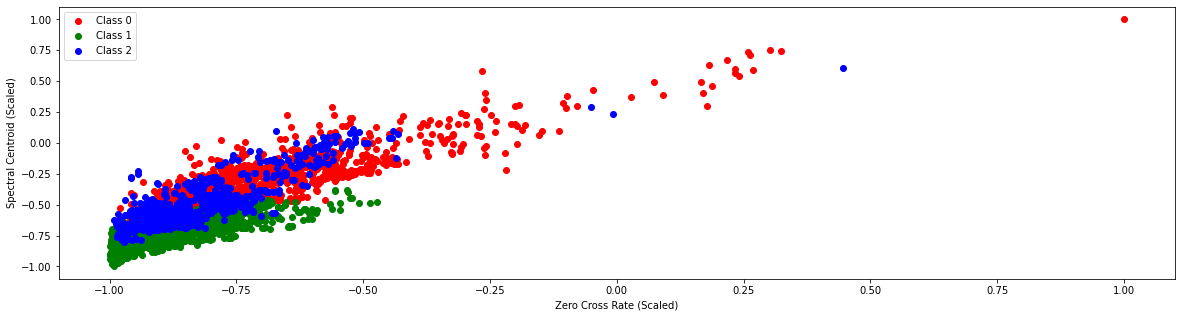

In [8]:
sound_bank = generate_soundbank(lofi, srate)

In [ ]:
ipd.Audio(np.concatenate(sound_bank[0]), rate=srate)

In [ ]:
ipd.Audio(np.concatenate(sound_bank[1]), rate=srate)

In [ ]:
ipd.Audio(np.concatenate(sound_bank[2]), rate=srate)

In [ ]:
ipd.Audio(np.concatenate(sound_bank[3]), rate=srate)

## Genetic Algorithm

In [ ]:
def fitness_fn(genome, mfccs, afs):
    '''
    Determines if the given genome is fit enough
    
    creates a AF and MFCC vector of the genome and compares with the mfccs and afs
    
    params:
        genome: a generated audio data array
        mfcss: the MFCC vectors of Lofi and non-Lofi
        afs: the Audio Fingerprints of Lofi and non-Lofi
        
    returns:
        fitness_value: A rating based on all produced heuristics
    '''
    # Heuristics
    af = audio_fingerprint(genome)
    mgcc = generate_mfcc(genome)
    
    # TODO: create fitness_value based on heuristics
    fitness_value = 0
    
    return fittness_value


def generate_genome(sound_bank):
    '''
    Creates a random genome from available sounds
    
    params:
        sounds: the possible sounds to be uses for creating genomes
        
    returns:
        genome: a random genome based of available sounds
    '''
    #TODO
    genome = []
    return genome


def generate_population(pop_size, sound_bank):
    '''
    Creates pop_size number of genomes from available sounds
    
    params:
        pop_size: the number of genomes to produce
        sounds: the possible sounds to be uses for creating genomes
        
    returns:
        population: a list of genomes with length of pop_size
    '''
    population = []
    
    for i in range(pop_size):
        population.append(generate_genome(sound_bank))
        
    return population


def choose_parents(population, weights):
    '''
    Choose 2 parents from population, better genomes are more likely to be choosen
    
    params:
        population: list of genomes
        weights: list of weights
        
    returns:
        parents: A list of 2 genomes
    '''
    return choices(population, weights=weights, k=2)


def single_point_crossover(parents):
    '''
    Creates 2 new children from sections of both parents
    
    params:
        parents: A list of 2 parents genomes
        
    returns:
        children: 2 new genomes based of a combination of both parents
    '''
    parent_a = parents[0]
    parent_b = parents[1]
    # Ensure a and b have same length
    if len(parent_a) != len(parent_b):
        raise ValueError("Genomes not equal length\n")
        
    split_point = randint(1, len(parent_a)-1)
    child_a = parent_a[:split_pont] + parent_b[split_point:]
    child_b = parent_b[:split_pont] + parent_a[split_point:]
    children = [child_a, child_b]
    return children


def mutate(genome):
    '''
    Mutates values from a genome at random
    
    params:
        genome: a generated audio data array
        
    returns:
        mutated_genome: a mutated verion of the inputed genome
    '''
    #TODO
    return genome


def new_gen(population, weights):
    '''
    Creates the next generations population
    
    params:
        population: list of genomes
        weights: list of weights
        
    returns:
        new_population: A list of genomes ordered by rank
    '''
    new_population = []
    for i in range(len(population)/2):
        parents = choose_parents(population, weights)
        children = single_point_crossover(parents)
        for i in range(children):
            children[i] = mutate(children[i])
        new_population += children
    
    return new_population


def genetic_algorithm(sound_bank, mfccs, afs):
    '''
    Generates a lofi audio clip using a genetic algorithm
    
    The fitness function will use the mfccs and afs to see if its close enough to lofi
    
    params:
        sound_bank: the catagorized, grouped, sounds of lofi to use to make the audio clip.
        mfcss: the MFCC vectors of Lofi and non-Lofi
        afs: the Audio Fingerprints of Lofi and non-Lofi
        
    returns:
        a data array of generated lofi
    '''
    # Number of generations until exit
    generations = 100
    # Generate 6 unique melodies
    population = generate_population(6, sound_bank)
    
    for gen in range(generations):
        # Get weights
        weights = []
        for genome in population:
            weights.append(fitness_fn(genome, mfcss, afs))
            
        # Create next generation genomes
        population = new_gen(population, weights)
        
    return population
